### Daytum Course: Spatial Data Analytics

### Trend Modeling

Calculate data-driven trend for a spatial dataset.

#### Description

Here's a simple, documented workflow, demonstration of trend calculation and diagnostics for subsurface modeling workflows. This should help you get started with building subsurface models that integrate trends.  

#### Trend Modeling

Trend modeling is the modeling of local features, based on data and interpretation, that are deemed certain (known).  The trend is substracted from the data, leaving a residual that is modeled stochastically with uncertainty (treated as unknown).

* geostatistical spatial estimation methods will make an assumption concerning stationarity
    * in the presence of significant nonstationarity we can not rely on spatial estimates based on data + spatial continuity model
* if we observe a trend, we should model the trend.
    * then model the residuals stochastically
    
Trend modeling significantly improves our models by accounting for the nonstationary map-able component of the spatial property.  Consider this spatial model in 1D with and without trend.

At a distance beyond the range of spatial continuity away from the data, the best estimate approaches the global mean or the trend model.  WIthout the trend model we would systemally underestimate in the high regions and overestimate in the low regions.

Steps: 

1. model trend consistent with data and intepretation at all locations within the area of itnerest, integrate all available information and expertise.

\begin{equation}
m(\bf{u}_\beta), \, \forall \, \beta \in \, AOI
\end{equation}

2. substract trend from data at the $n$ data locations to formulate a residual at the data locations.

\begin{equation}
y(\bf{u}_{\alpha}) = z(\bf{u}_{\alpha}) - m(\bf{u}_{\alpha}), \, \forall \, \alpha = 1, \ldots, n
\end{equation}

3. characterize the statistical behavoir of the residual $y(\bf{u}_{\alpha})$ integrating any information sources and interpretations.  For example the global cumulative distribution function and a measure of spatial continuity shown here.

\begin{equation}
F_y(y) \quad \gamma_y(\bf{h})
\end{equation}

4. model the residual at all locations with $L$ multiple realizations.

\begin{equation}
Y^\ell(\bf{u}_\beta),  \, \forall \, \beta \, \in \, AOI; \, \ell = 1, \ldots, L
\end{equation}

5. add the trend back in to the stochastic residual realizations to calculate the multiple realizations, $L$, of the property of interest based on the composite model of known deterministic trend, $m(\bf{u}_\alpha)$ and unknown stochastic residual, $y(\bf{u}_\alpha)$ 

\begin{equation}
Z^\ell(\bf{u}_\beta) = Y^\ell(\bf{u}_\beta) + m(\bf{u}_\beta),  \, \forall \, \beta \in \, AOI; \, \ell = 1, \ldots, L
\end{equation}

6. check the model, including quantification of the proportion of variance treated as known (trend) and unknown (residual).

\begin{equation}
\sigma^2_{Z} = \sigma^2_{Y} + \sigma^2_{m} + 2 \cdot C_{Y,m}
\end{equation}

given $C_{Y,m} \to 0$:

\begin{equation}
\sigma^2_{Z} = \sigma^2_{Y} + \sigma^2_{m}
\end{equation}

I can now describe the proportion of variance allocated to known and unknown components as follows:

\begin{equation}
Prop_{Known} = \frac{\sigma^2_{m}}{\sigma^2_{Y} + \sigma^2_{m}} \quad Prop_{Unknown} = \frac{\sigma^2_{Y}}{\sigma^2_{Y} + \sigma^2_{m}}
\end{equation}

I provide some practical, data-driven methods for trend model, but I should indicate that:

1. trend modeling is very important in reservoir modeling as it has large impact on local model accuracy and on the undertainty model
2. trend modeling is used in almost every subsurface model, unless the data is dense enough to impose local trends
3. trend modeling includes a high degree of expert judgement combined with the integration of various information sources

We limit ourselves to simple data-driven methods, but acknowledge much more is needed. In fact, trend modeling requires a high degree of knowledge concerning local geoscience and engineering data and knowledge.  

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
from intake import cat
import warnings
warnings.filterwarnings('ignore')

#### Loading Tabular Data

Here's the command to load our Pandas' DataFrame object.  

In [5]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
#df = cat.sample_data_biased.read()     # load our data table

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [6]:
print(df.iloc[0:5,:])                   # display first 4 samples in the table as a preview
df.head(n=13)                           # we could also use this command for a table preview

     X    Y  Facies  Porosity       Perm
0  100  900       1  0.115359   5.736104
1  100  800       1  0.136425  17.211462
2  100  600       1  0.135810  43.724752
3  100  500       0  0.094414   1.609942
4  100  100       0  0.113049  10.886001


,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001
5,200,800,1,0.154648,106.491795
6,200,700,1,0.153113,140.976324
7,200,500,1,0.126167,12.548074
8,200,400,0,0.094750,1.208561
9,200,100,1,0.150961,44.687430


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 2 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
nx = 100; ny = 100; csize = 10.0
cmap = plt.cm.plasma                    # color map

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

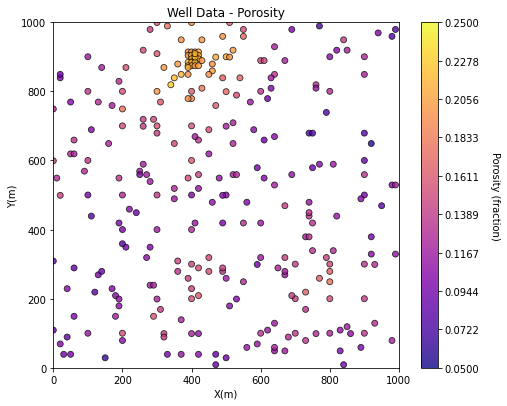

In [10]:
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Let's get some declustering weights. For more information see the demonstration on declustering.

In [11]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


,X,Y,Facies,Porosity,Perm,Wts
0,100,900,1,0.115359,5.736104,3.064286
1,100,800,1,0.136425,17.211462,1.076608
2,100,600,1,0.135810,43.724752,0.997239
3,100,500,0,0.094414,1.609942,1.165119
4,100,100,0,0.113049,10.886001,1.224164


#### Trend by Convolution / Local Window Average

Let's first attempt a convolution-based trend model, this is a moving window average of the local data.

We have a convenience function that takes data with X and Y locations in a DataFrame and makes a sparse 2D array.  All cells without a data value are assigned to NumPy's NaN (null values, missing value). Let's see the inputs for this command.

In [12]:
GSLIB.DataFrame2ndarray

<function geostatspy.GSLIB.DataFrame2ndarray(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, step)>

Let's make an sparse array with the appropriate parameters. The reason we are doing this is that convolution programs in general work with ndarrays and not from DataFrames.

In [13]:
por_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Porosity',xmin, xmax, ymin, ymax, csize)

We have a ndarray (por_grid) with the data assigned to grid cells. Now we need a kernel. The kernel represents the weights within the moving window. If we use constant 1.0 in the moving window will get discontinuities in our trend model. A Gaussian kernel (weights highest in the middle of the window and decreasing to 0,0 at the edge) is useful to get a smooth trend. We can use the SciPy package's signal functions. Of course we will have to import that package and then we can make our kernel. Here's an example below. There shouldnt be any surprises. 

We have made a kernel of size, number of grid cells (ny, nx) (53, 53)


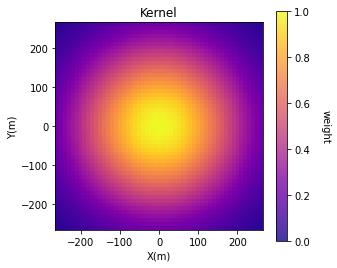

In [14]:
gkern1d = signal.gaussian(53,15).reshape(53, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=-265,xmax=265,ymin=-265,ymax=265,step=10,vmin=0,vmax=1,title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

Now we need to convolve our sparse data assigned to a ndarray with our Gaussian kernel. There are many functions available for convolution. But we have a problem as we want to apply our Gaussian kernel to a sparse ndarray full of missing values. It turns out this is a common issue for our friends in Astronomy and so their Astropy package has a convolution method that will work well. I figured out the following (so you don't have to!).

In [15]:
import astropy.convolution.convolve as convolve
porosity_trend = convolve(por_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

No errors? It worked? Let's look at the results. We can plot and compare the original porosity data and the resulting trend to check for consistency.

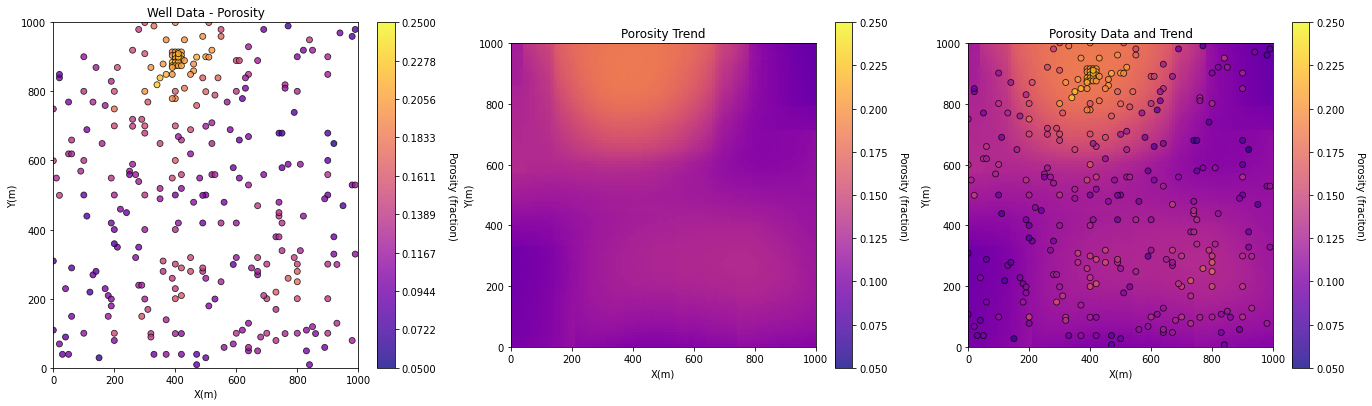

In [16]:
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(132)
GSLIB.pixelplt_st(porosity_trend,xmin,xmax,ymin,ymax,csize,pormin,pormax,'Porosity Trend','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(133)
GSLIB.locpix_st(porosity_trend,xmin,xmax,ymin,ymax,csize,pormin,pormax,df,'X','Y','Porosity','Porosity Data and Trend','X(m)','Y(m)','Porosity (fraciton)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()


#### Other Methods for Trend Calculation

There are a variety of other methods for trend calculation. I will just mention them here.

1. hand-drawn, expert interpretation - many 3D modeling packages allow for experts to draw trends and allow for fast interpolation to build an exhaustive trend model.
2. kriging - kriging provides best linear unbiased estimates between data given a spatial continuity model (more on this when we cover spatial estimation).  One note of caution is that kriging is exact; therefore it will over fit unless it is use with averaged data values (e.g. over the vertical) or with a block kriging option (kriging at a volume support larger than the data).
3. regression - fit a function as a function of X, Y coordinates. This could be extended to more complicated prediction models from machine learning.

#### Adding Trend to DataFrame

Let's add the porosity trend to our DataFrame. We have a sample program in GeostatsPy that takes a 2D ndarray and extracts the values at the data locations and adds them as a new column.  Then we can do a little math to calculate and add the porosity residual also and visualize this all together as a final check.

In [17]:
df = GSLIB.sample(porosity_trend,xmin,ymin,csize,"Por_Trend",df,'X','Y')
df['Por_Res'] = df['Porosity'] - df['Por_Trend'] # calculate the residual and add to DataFrame

Let's check out the DataFrame and confirm that we have everything now. We will need trend and residual in our DataFrame to support all subsequent modeling steps.

In [18]:
df.head()

,X,Y,Facies,Porosity,Perm,Wts,Por_Trend,Por_Res
0,100,900,1,0.115359,5.736104,3.064286,0.139280,-0.023921
1,100,800,1,0.136425,17.211462,1.076608,0.134714,0.001711
2,100,600,1,0.135810,43.724752,0.997239,0.129281,0.006529
3,100,500,0,0.094414,1.609942,1.165119,0.120029,-0.025615
4,100,100,0,0.113049,10.886001,1.224164,0.101258,0.011790


#### Trend Diagnotistics

Let's go back to the convolution trend and check it (to demonstrate the method of trend checking). Note, I haven't tried to perfect the result. I'm just demonstrating the method. 

In addition to the previous visualization, let's look at the distributions and summary statistics of the original declustered porosity data and the trend.

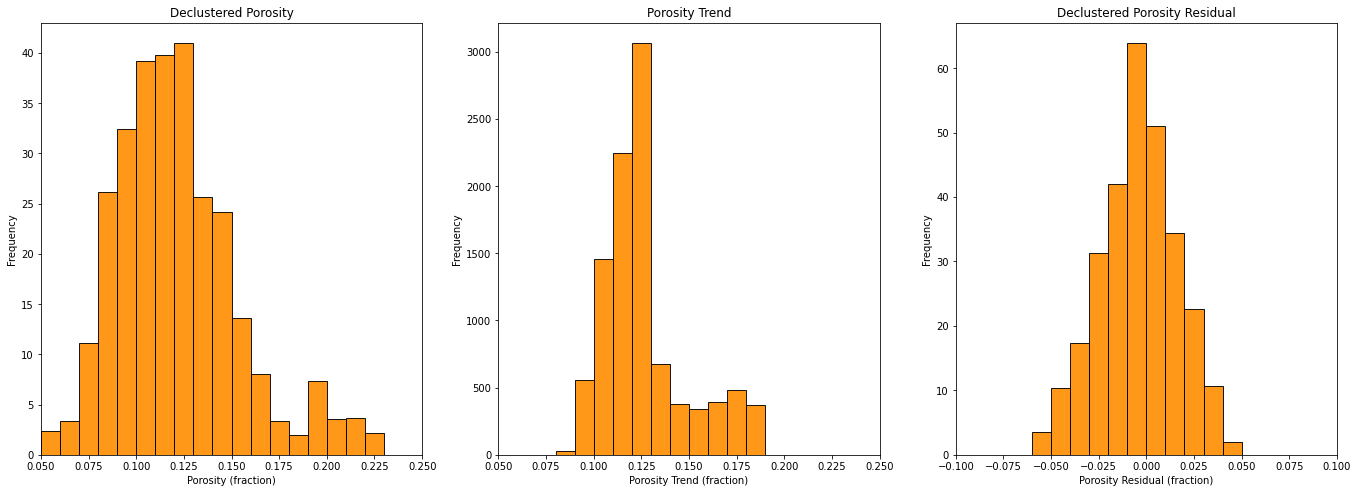

In [19]:
plt.subplot(131)
GSLIB.hist_st(df['Porosity'],pormin,pormax,False,False,20,df['Wts'],'Porosity (fraction)','Declustered Porosity')

plt.subplot(132)
GSLIB.hist_st(porosity_trend.flatten(),pormin,pormax,False,False,20,None,'Porosity Trend (fraction)','Porosity Trend')

plt.subplot(133)
GSLIB.hist_st(df['Por_Res'],-.1,.1,False,False,20,df['Wts'],'Porosity Residual (fraction)','Declustered Porosity Residual')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

We can also look at the summary statistics. Here's a function that calculates the weighted standard deviation (and the average). We can use this with the data and declustering weights and figure out the allocation of variance between the trend and the residual.  

We will calculated the proportion of variance in the trend and the residual.  This includes the following steps:

* calculate the representative weighted standard deviation of the original data, convert to variance, $\sigma$

* calculate the standard deviation of the trend model, convert to variance, $\sigma_t$

* calculate the variance of the residual at the data locations, $\sigma_r$ 

* back calculate the covariance form the relationship:

\begin{equation}
\sigma = \sigma_t + \sigma_r + 2 \times C_{tr}
\end{equation}

When we analyze the trend contributions we observe that:

* 48% of the variance is captured by the trend model

* 41% of the variance is captured in the residual

* 11% of the vairance remains in the coveriance term

That looks good. A quick check, confirm that the Porosity column is equal to the Por_Trend + the Por_Res columns.  As a final check let's visualize the original porosity data, porosity trends at the data locations and the porosity residuals. 

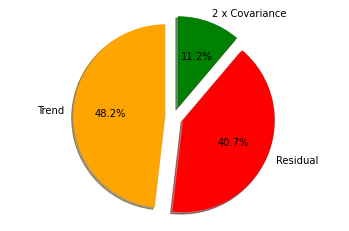

Declustered Porosity Data: Average 0.1212, Var 0.00102
Porosity Residual: Average         -0.0041, Var 0.00041
Proportion Trend / Known:          0.482
Proportion Residual / Unknown:     0.518


In [20]:
# Weighted average and standard deviation
def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

wavg_por,wstd_por = weighted_avg_and_std(df['Porosity'],df['Wts']) 
var_por_trend = np.var(porosity_trend.flatten())
wavg_por_res,wstd_por_res = weighted_avg_and_std(df['Por_Res'],df['Wts']) 

prop_trend = var_por_trend/(wstd_por**2)
prop_resid = (wstd_por_res**2)/(wstd_por**2)
prop_cov = 1 - prop_trend - prop_resid

variance_prop = [prop_trend, prop_resid, prop_cov]
labels = 'Trend', 'Residual', '2 x Covariance'
colors = 'orange', 'red', 'green'
explode = (0.1, 0.1,0.1)

fig1, ax1 = plt.subplots()
ax1.pie(variance_prop, explode=explode, colors = colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

print('Declustered Porosity Data: Average ' + str(round(wavg_por,4)) + ', Var ' + str(round(wstd_por**2,5)))
print('Porosity Residual: Average         ' + str(round(wavg_por_res,4)) + ', Var ' + str(round(wstd_por_res**2,5)))
print('Proportion Trend / Known:          ' + str(round(var_por_trend/(wstd_por**2),3)))
print('Proportion Residual / Unknown:     ' + str(round((wstd_por**2 - var_por_trend)/(wstd_por**2),3)))

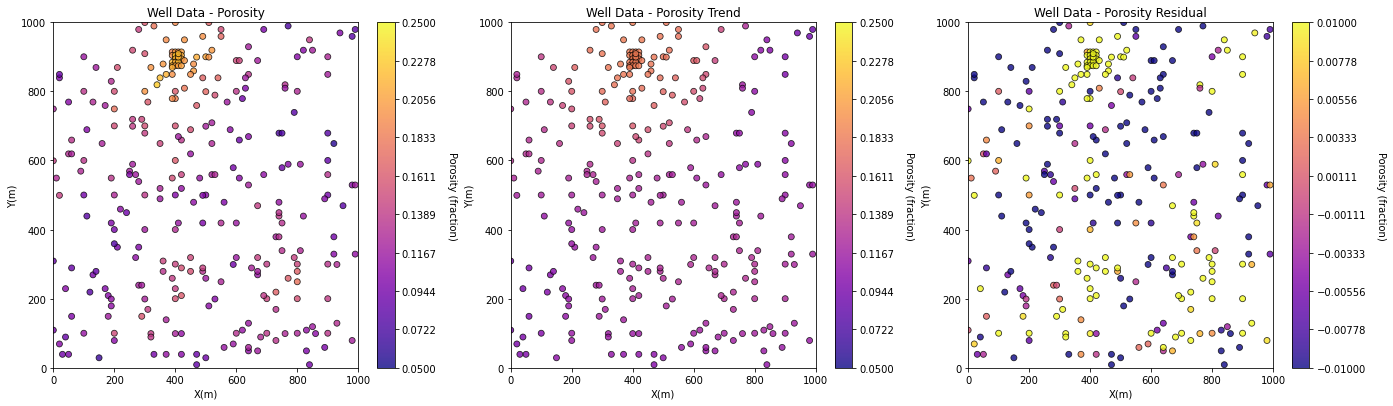

In [21]:
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(132)
GSLIB.locmap_st(df,'X','Y','Por_Trend',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity Trend','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(133)
GSLIB.locmap_st(df,'X','Y','Por_Res',xmin,xmax,ymin,ymax,-0.01,0.01,'Well Data - Porosity Residual','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Does it look correct? There is a strong degree of consistency between the porosity data and trend and the porosity residual no longer has a trend, it has been detrended.

We should also check for conditional bias.  Let's look at the porosity residuals vs. the porosity trend.  

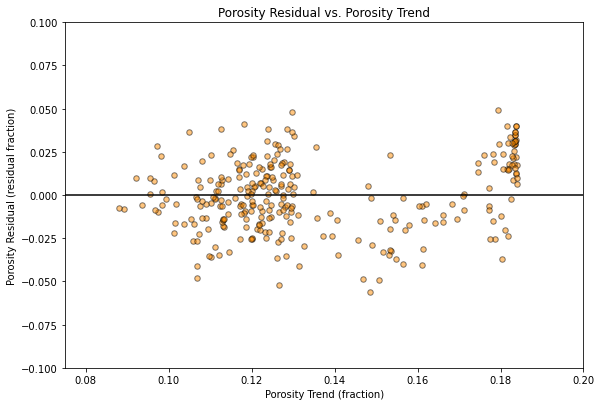

In [24]:
plt.subplot(111)
plt.scatter(df['Por_Trend'],df['Por_Res'], s=30, alpha = 0.5, edgecolors = "black", facecolors = 'darkorange')
plt.xlabel('Porosity Trend (fraction)')
plt.ylabel('Porosity Residual (residual fraction)')
plt.title('Porosity Residual vs. Porosity Trend')
plt.plot([0,2000],[0,0],color = 'black')
plt.ylim(-0.1,0.1)
plt.xlim(0.075,0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

There does not appear to be a consistent conditional bias, although we could argue that the high porosity trend locations are systematical underestimated (looks like the conditional residual mean is > 0).  Doesn't look too serious.

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>